# Cross validation of cox regressor

Cross validation is an improtant tool for evaluating the performance (or true risk) of your model.
But with Cox regressor it can lead to some unstable results, especially with increased fold count.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lifelines import CoxPHFitter
from lifelines.datasets import load_leukemia
from sklearn.model_selection import KFold

from scipy.stats import gaussian_kde
from tqdm import tqdm

In [2]:
data = load_leukemia()
data["t"] += np.arange(len(data))*1e-9
print(f"Number of samples: {len(data)}")
data.head()

Number of samples: 42


,t,status,sex,logWBC,Rx
0,35.0,0,1,1.45,0
1,34.0,0,1,1.47,0
2,32.0,0,1,2.20,0
3,32.0,0,1,2.53,0
4,25.0,0,1,1.78,0


## Cross-validation regimes

In [3]:
def log_likelihood(partial_hazard:np.array, events:np.array) -> float:
    sum_at_risk = np.log(np.cumsum(np.e**(partial_hazard)))
    log_likelihood_ = np.sum(events * (partial_hazard - sum_at_risk))
    return log_likelihood_

def log_likelihood_from_cox(cox:CoxPHFitter, X:pd.DataFrame) -> float:
    
    X_ = X.copy()
    X_ = X_.sort_values(by=["t"], ascending=False)
    events = X_["status"].values
    partial_hazard = cox.predict_log_partial_hazard(X_).values

    return log_likelihood(partial_hazard, events)

def log_likelihood_from_linear_predictors(lin_pred:pd.Series, data:pd.DataFrame) -> float:

    values = pd.concat((data, pd.concat(lin_pred)), axis=1).sort_values(by=["t"])

    return log_likelihood(values[0], values["status"])


In [4]:
def traditional_cross_validation(cox:CoxPHFitter, X_test:pd.DataFrame) -> float:
    return log_likelihood_from_cox(cox, X_test)

def verweij_and_van_houwelingen(cox:CoxPHFitter, X_train:pd.DataFrame, X_test:pd.DataFrame):

    train_likelihood = log_likelihood_from_cox(cox, X_train)
    whole_likelihood = log_likelihood_from_cox(cox, pd.concat((X_train, X_test)))

    return whole_likelihood - train_likelihood

## Cross-validation

In [5]:
cve_estimate = {
    "traditional": [],
    "V_&_VH": [],
    "lin_pred": []
}

for i in tqdm(range(20)):
    cv_metric = {
        "traditional": [],
        "V_&_VH": [],
        "lin_pred": []
    }
    cv_linear_predictor = []

    kfold = KFold(n_splits=10, shuffle=True, random_state=i)

    for train_ids, test_ids in kfold.split(data):
        X_train, X_test = data.iloc[train_ids], data.iloc[test_ids]

        cox = CoxPHFitter()
        cox.fit(X_train, "t", "status")

        cv_metric["traditional"].append(traditional_cross_validation(cox, X_test))
        cv_metric["V_&_VH"].append(verweij_and_van_houwelingen(cox, X_train, X_test))
        cv_metric["lin_pred"].append(cox.predict_log_partial_hazard(X_test))
    
    cve_estimate["traditional"].append(-2 * np.sum(cv_metric["traditional"]))
    cve_estimate["V_&_VH"].append(-2 * np.sum(cv_metric["V_&_VH"]))
    cve_estimate["lin_pred"].append(-2 * log_likelihood_from_linear_predictors(cv_metric["lin_pred"], data))


100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


In [6]:
cv_metric = {
    "traditional": [],
    "V_&_VH": [],
    "lin_pred": []
}

kfold = KFold(n_splits=len(data), shuffle=True, random_state=0)

for train_ids, test_ids in kfold.split(data):
    X_train, X_test = data.iloc[train_ids], data.iloc[test_ids]

    cox = CoxPHFitter()
    cox.fit(X_train, "t", "status")

    cv_metric["traditional"].append(traditional_cross_validation(cox, X_test))
    cv_metric["V_&_VH"].append(verweij_and_van_houwelingen(cox, X_train, X_test))
    cv_metric["lin_pred"].append(cox.predict_log_partial_hazard(X_test))

cve_estimate["traditional"].append(-2 * np.sum(cv_metric["traditional"]))
cve_estimate["V_&_VH"].append(-2 * np.sum(cv_metric["V_&_VH"]))
cve_estimate["lin_pred"].append(-2 * log_likelihood_from_linear_predictors(cv_metric["lin_pred"], data))

## Plotting results

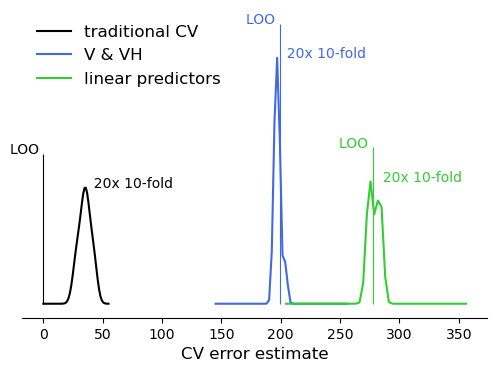

In [7]:
f, ax = plt.subplots(1,1, figsize=(6,4))

labels = ["traditional CV", "V & VH", "linear predictors"]
colors = ["k", "royalblue", "limegreen"]

for label, cve, color in zip(labels, cve_estimate.values(), colors):
    kde = gaussian_kde(cve[:-1])
    x_range = np.linspace(np.min(cve)*0.75, np.max(cve)*1.25)
    
    ax.plot(x_range, kde(x_range), label=label, color=color)

    peak = np.max(kde(x_range)) + 0.02
    ax.vlines(cve[-1], 0, peak, color=color, lw=0.8)
    ax.text(cve[-1], peak, "LOO ", fontsize=10, color=color,
            horizontalalignment="right")
    
    ax.text(np.mean(cve[:-1]), peak-0.02, f"  20x 10-fold", fontsize=10, color=color,)

ax.legend(frameon=False, fontsize=12, loc=2)

for loc in ["top", "right", "left"]:
    ax.spines[loc].set_visible(False)

ax.set_xlabel("CV error estimate", fontsize=12)
ax.yaxis.set_visible(False)

f.savefig("CVE_comparison.png", dpi=300, bbox_inches="tight")